In [67]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import heapq
import wandb
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30

In [69]:
class Lang:
    def __init__(self, name):
        """
        Constructor for Lang class
        name: name of the language
        """
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def addWord(self, word):
        """
        Add a word to the language
        word: word to be added
        """
        for char in word:
            self.addChar(char)

    def addChar(self, char):
        """
        Add a character to the language
        char: character to be added
        """
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [70]:
def readLangs(lang, type, reverse=False):
    """
    Read the data file and split into lines
    lang: language of the output
    type: type of the data file, i.e., train, test, or val
    reverse: reverse the pairs or not
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('aksharantar_sampled/%s/%s_%s.csv' % (lang, lang, type), encoding='utf-8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[s for s in l.split(',')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang)
        output_lang = Lang('eng')
    else:
        input_lang = Lang('eng')
        output_lang = Lang(lang)

    return input_lang, output_lang, pairs

In [71]:
def prepareData(lang, reverse=False):
    """
    Prepare the data for training and testing
    lang: language of the output
    reverse: reverse the pairs or not
    """
    input_lang, output_lang, pairs = readLangs(lang, reverse)
    print("Read %s word pairs" % len(pairs))
    print("Trimmed to %s word pairs" % len(pairs))
    print("Counting chars...")
    for pair in pairs:
        input_lang.addWord(pair[0])
        output_lang.addWord(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('mni', 'train')
print(random.choice(pairs))

Reading lines...
Read 10060 word pairs
Trimmed to 10060 word pairs
Counting chars...
Counted chars:
eng 28
mni 46
['ngasi', 'ꯉꯁꯤ']


In [72]:
cells = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}

In [73]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_hidden_layers, dropout=0.2, cell_type='gru'):
        """
        Constructor for EncoderRNN class
        input_size: size of the input
        embedding_size: size of the embedding employed for the input
        hidden_size: size of the hidden state in the cell
        num_hidden_layers: number of hidden layers in the cell
        dropout: dropout rate
        cell_type: type of the cell, i.e., rnn, gru, or lstm
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.cell_type = cell_type
        self.cell = cells[cell_type](embedding_size, hidden_size, num_hidden_layers, dropout=dropout)

    def forward(self, input, hidden, cell=None):
        """
        Forward propagation of the encoder
        input: input to the encoder
        hidden: hidden state of the encoder
        cell: cell state of the encoder, only for LSTM

        Returns: output and hidden state of the encoder
        """
        embedded = self.embedding(input).view(1, 1, -1)
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            output, hidden = self.cell(embedded, hidden)
            return output, hidden
        else:
            output, (hidden, cell) = self.cell(embedded, (hidden, cell))    
            return output, hidden, cell

    def initHidden(self):
        """
        Initialize the hidden state of the encoder

        Returns: initialized hidden state of the encoder
        """
        return torch.zeros(self.num_hidden_layers, 1, self.hidden_size, device=device)

In [74]:
class BeamSearchNode:
    def __init__(self, decoder_output, hidden, prev_node, char_idx, log_prob, length):
        """
        Constructor for BeamSearchNode class
        decoder_output: output of the decoder
        hidden: hidden state of the decoder
        prev_node: previous node in the beam search
        char_idx: index of the character
        log_prob: log probability of the character
        length: length of the sequence
        """
        self.decoder_output = decoder_output
        self.hidden = hidden
        self.prev_node = prev_node
        self.char_idx = char_idx
        self.log_prob = log_prob
        self.length = length

    def eval(self):
        """ 
        Evaluate the node for the beam search, i.e., return the average log probability

        Returns: Average log probability of the node
        """
        return self.log_prob / self.length

In [75]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, num_hidden_layers, dropout=0, cell_type='gru'):
        """
        Constructor for DecoderRNN class
        hidden_size: size of the hidden state in the cell
        embedding_size: size of the embedding employed for the input
        output_size: size of the output
        num_hidden_layers: number of hidden layers in the cell
        dropout: dropout
        cell_type: type of the cell, i.e., rnn, gru, or lstm
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.cell_type = cell_type
        self.cell = cells[cell_type](embedding_size, hidden_size, num_hidden_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, output_size)
        self.output_size = output_size
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell=None):
        """
        Forward propagation of the decoder
        input: input to the decoder
        hidden: hidden state of the decoder
        cell: cell state of the decoder, only for LSTM

        Returns: output and hidden state of the decoder
        """
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            output, hidden = self.cell(output, hidden)
        else:
            output, (hidden, cell) = self.cell(output, (hidden, cell))
            
        output = self.softmax(self.out(output[0]))

        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            return output, hidden
        else:
            return output, hidden, cell
    
    def initHidden(self):
        """
        Initialize the hidden state of the decoder

        Returns: initialized hidden state of the decoder
        """
        return torch.zeros(self.num_hidden_layers, 1, self.hidden_size, device=device)

    def beam_search(self, encoder_outputs, decoder_hidden, beam_width, max_length, start_token, end_token):
        """
        Beam search for the decoder
        encoder_outputs: outputs of the encoder
        decoder_hidden: hidden state of the decoder
        beam_width: width of the beam
        max_length: maximum length of the sequence
        start_token: start token
        end_token: end token
        
        Returns: predicted sequence
        """
        # Initialize the beam search
        beam_nodes = [BeamSearchNode(None, decoder_hidden, None, start_token, 0, 1)]
        done_nodes = []

        # Keep expanding the beam until we reach the maximum length or all candidates are done
        for _ in range(max_length):
            candidates = []
            for node in beam_nodes:
                if node.char_idx == end_token:
                    done_nodes.append(node)
                    continue

                # Feed the previous char and hidden state into the decoder
                output, hidden = self.forward(torch.tensor([node.char_idx]), node.hidden)
                # Single depth or double depth for tensor?

                # Generate new candidate nodes and add them to the heap
                for char_idx in range(self.output_size):
                    length = node.length + 1
                    log_prob = node.log_prob + output[0][char_idx].item()
                    new_node = BeamSearchNode(output, hidden, node, char_idx, log_prob, length)
                    heapq.heappush(candidates, (-new_node.eval(), id(new_node), new_node))

            # Select the top k candidates to continue expanding the beam
            beam_nodes = []
            for _ in range(beam_width):
                if not candidates:
                    break
                _, _, node = heapq.heappop(candidates)
                beam_nodes.append(node)

            if not beam_nodes:
                break

        # Return the best candidate as the predicted sequence
        done_nodes.extend(beam_nodes)
        best_node = max(done_nodes, key=lambda node: node.eval())
        return best_node

In [76]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, num_hidden_layers, dropout=0.1, cell_type='gru', max_length=MAX_LENGTH):
        """
        Constructor for AttnDecoderRNN class
        hidden_size: size of the hidden state in the cell
        embedding_size: size of the embedding employed for the input
        output_size: size of the output
        num_hidden_layers: number of hidden layers in the cell
        dropout: dropout
        cell_type: type of the cell, i.e., rnn, gru, or lstm
        max_length: maximum length of the sequence
        """
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.cell_type = cell_type
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.embedding_size + self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.embedding_size + self.hidden_size, self.hidden_size)
        self.cell = cells[cell_type](self.hidden_size, self.hidden_size, self.num_hidden_layers, dropout=self.dropout)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, cell=None):
        """
        Forward propagation of the decoder
        input: input to the decoder
        hidden: hidden state of the decoder
        encoder_outputs: outputs of the encoder
        cell: cell state of the decoder, only for LSTM

        Returns: output and hidden state of the decoder
        """
        embedded = self.embedding(input).view(1, 1, -1)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            output, hidden = self.cell(output, hidden)
        else:
            output, (hidden, cell) = self.cell(output, (hidden, cell))

        output = F.log_softmax(self.out(output[0]), dim=1)

        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            return output, hidden, attn_weights
        else:
            return output, hidden, cell, attn_weights

    def initHidden(self):
        """
        initialize the hidden state of the decoder

        Returns: initialized hidden state of the decoder
        """
        return torch.zeros(self.num_hidden_layers, 1, self.hidden_size, device=device)

In [77]:
def indexesFromWord(lang, word):
    """
    Convert a word to its corresponding indices
    lang: language of the word
    word: word to be converted
    
    Returns: indices of the word
    """
    return [lang.char2index[char] for char in word]


def tensorFromWord(lang, word):
    """
    Convert a word to its corresponding tensor
    lang: language of the word
    word: word to be converted

    Returns: tensor of the word
    """
    indexes = indexesFromWord(lang, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    """
    Convert a pair of words to their corresponding tensors
    pair: pair of words to be converted

    Returns: tensors of the pair
    """
    input_tensor = tensorFromWord(input_lang, pair[0])
    target_tensor = tensorFromWord(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [78]:
teacher_forcing_ratio = 0.5


def trainVanilla(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, beam_width, max_length=MAX_LENGTH):
    """
    Train the vanilla model
    input_tensor: input tensor
    target_tensor: target tensor
    encoder: encoder model
    decoder: decoder model
    encoder_optimizer: optimizer for the encoder
    decoder_optimizer: optimizer for the decoder
    criterion: loss function
    beam_width: width of the beam
    max_length: maximum length of the sequence

    Returns: loss for the prediction
    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    if encoder.cell_type == 'lstm':
        encoder_cell = encoder.initHidden()

    loss = 0

    for ei in range(input_length):
        if encoder.cell_type == 'lstm':
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        else:
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_hidden = encoder_hidden

    if beam_width == 1:
        decoder_input = torch.tensor([[SOS_token]], device=device)

        if decoder.cell_type == 'lstm':
            decoder_cell = encoder_cell

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                if decoder.cell_type == 'lstm':
                    decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                if decoder.cell_type == 'lstm':
                    decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.item() / target_length
    
    else:
        best_node = decoder.beam_search(encoder_outputs, decoder_hidden, beam_width, target_length, SOS_token, EOS_token)

        decoder_outputs = []
        curr_node = best_node

        while curr_node.decoder_output is not None:
            decoder_outputs.append(curr_node.decoder_output)
            curr_node = curr_node.prev_node

        decoder_outputs = decoder_outputs[::-1]

        # Loss is the sum of the criterion of each decoder output with respect to the target
        loss = sum([criterion(decoder_output, target_tensor[i]) for i, decoder_output in enumerate(decoder_outputs)])
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.item() / target_length


In [79]:
teacher_forcing_ratio = 0.5


def trainAttention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, beam_width=1, max_length=MAX_LENGTH):
    """
    Train the attention-based model
    input_tensor: input tensor
    target_tensor: target tensor
    encoder: encoder model
    decoder: decoder model
    encoder_optimizer: optimizer for the encoder
    decoder_optimizer: optimizer for the decoder
    criterion: loss function
    beam_width: width of the beam
    max_length: maximum length of the sequence

    Returns: loss for the prediction
    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    if encoder.cell_type == 'lstm':
        encoder_cell = encoder.initHidden()
        
    loss = 0

    for ei in range(input_length):
        if encoder.cell_type == 'lstm':
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        else:
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_hidden = encoder_hidden

    if beam_width == 1:
        decoder_input = torch.tensor([[SOS_token]], device=device)

        if decoder.cell_type == 'lstm':
            decoder_cell = encoder_cell

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                if decoder.cell_type == 'lstm':
                    decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, decoder_cell)
                else:
                    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                if decoder.cell_type == 'lstm':
                    decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, decoder_cell)
                else:
                    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                    
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.item() / target_length
    
    else:
        best_node = decoder.beam_search(encoder_outputs, decoder_hidden, beam_width, target_length, SOS_token, EOS_token)

        decoder_outputs = []
        curr_node = best_node

        while curr_node.decoder_output is not None:
            decoder_outputs.append(curr_node.decoder_output)
            curr_node = curr_node.prev_node

        decoder_outputs = decoder_outputs[::-1]

        # Loss is the sum of the criterion of each decoder output with respect to the target
        loss = sum([criterion(decoder_output, target_tensor[i]) for i, decoder_output in enumerate(decoder_outputs)])
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.item() / target_length

In [80]:
def asMinutes(s):
    """
    Convert seconds to minutes
    s: seconds

    Returns: minutes and seconds
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """
    Calculate the time since the start of training

    Returns: time since the start of training
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [81]:
def evaluateVanilla(encoder, decoder, word, beam_width=1, max_length=MAX_LENGTH):
    """
    Evaluate the vanilla model
    encoder: encoder model
    decoder: decoder model
    word: word to be evaluated
    beam_width: width of the beam
    max_length: maximum length of the sequence

    Returns: decoded sequence
    """
    with torch.no_grad():
        input_tensor = tensorFromWord(input_lang, word)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        if encoder.cell_type == 'lstm':
            encoder_cell = encoder.initHidden()

        for ei in range(input_length):
            if encoder.cell_type == 'lstm':
                encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            else:
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
                
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_hidden = encoder_hidden

        if beam_width == 1:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

            if encoder.cell_type == 'lstm':
                decoder_cell = encoder_cell

            decoded_chars = ""

            for di in range(max_length):
                if decoder.cell_type == 'lstm':
                    decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                    
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_chars += '<EOS>'
                    break
                else:
                    decoded_chars += output_lang.index2char[topi.item()]

                decoder_input = topi.squeeze().detach()

            return decoded_chars
        
        else:
            predicted_seq = decoder.beam_search(encoder_outputs, decoder_hidden, beam_width, SOS_token, EOS_token)
            return ''.join([output_lang.index2char[char_idx] for char_idx in predicted_seq])

In [82]:
def evaluateAttention(encoder, decoder, word, beam_width=1, max_length=MAX_LENGTH):
    """
    Evaluate the attention-based model
    encoder: encoder model
    decoder: decoder model
    word: word to be evaluated
    beam_width: width of the beam
    max_length: maximum length of the sequence
    
    Returns: decoded sequence
    """
    with torch.no_grad():
        input_tensor = tensorFromWord(input_lang, word)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        if encoder.cell_type == 'lstm':
            encoder_cell = encoder.initHidden()

        for ei in range(input_length):
            if encoder.cell_type == 'lstm':
                encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            else:
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_hidden = encoder_hidden

        if beam_width == 1:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

            if decoder.cell_type == 'lstm':
                decoder_cell = encoder_cell

            decoded_chars = ""
            decoder_attentions = torch.zeros(max_length, max_length)

            for di in range(max_length):
                if decoder.cell_type == 'lstm':
                    decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, decoder_cell)
                else:
                    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_chars += '<EOS>'
                    break
                else:
                    decoded_chars += output_lang.index2char[topi.item()]

                decoder_input = topi.squeeze().detach()

            return decoded_chars, decoder_attentions[:di + 1]
        
        else:
            predicted_seq = decoder.beam_search(encoder_outputs, decoder_hidden, beam_width, SOS_token, EOS_token)
            return ''.join([output_lang.index2char[char_idx] for char_idx in predicted_seq])

In [83]:
input_valid_lang, output_valid_lang, valid_pairs = prepareData('mni', 'valid')
input_test_lang, output_test_lang, test_pairs = prepareData('mni', 'test')

def evalAccuracy(eval_func, encoder, decoder, pairs):
    """
    Evaluate the accuracy of the model
    eval_func: evaluation function
    encoder: encoder model
    decoder: decoder model
    pairs: pairs to be evaluated

    Returns: accuracy of the model
    """
    correct = 0
    for pair in pairs:
        if eval_func == evaluateVanilla:
            output_word = eval_func(encoder, decoder, pair[0])
        else:
            output_word, _ = eval_func(encoder, decoder, pair[0])
        if output_word[-5:] == '<EOS>':
            output_word = output_word[:-5]
        if output_word == pair[1]:
            correct += 1
    return correct / len(pairs)

Reading lines...
Read 3260 word pairs
Trimmed to 3260 word pairs
Counting chars...
Counted chars:
eng 28
mni 46
Reading lines...
Read 4096 word pairs
Trimmed to 4096 word pairs
Counting chars...
Counted chars:
eng 28
mni 46


In [84]:
def trainBatch(train_func, encoder, decoder, epochs, optimizer=optim.SGD, beam_width=1, print_every=1000, learning_rate=5e-3, log=False):
    """
    Train the model in batches
    train_func: training function
    encoder: encoder model
    decoder: decoder model
    epochs: number of epochs
    optimizer: optimizer
    beam_width: width of the beam
    print_every: print every number of iterations
    learning_rate: learning rate
    log: whether to log the results or not
    """
    start = time.time()
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optimizer(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optimizer(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(pair) for pair in pairs]
    criterion = nn.NLLLoss()

    for iter in range(1, len(training_pairs) * epochs + 1):
        training_pair = training_pairs[(iter - 1) % len(training_pairs)]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_func(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, beam_width)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / (len(training_pairs) * epochs)), iter, iter / (len(training_pairs) * epochs) * 100, print_loss_avg))

        if log:
            wandb.log({"train_loss": loss})

            if iter % len(training_pairs) == 0:
                wandb.log({"train_accuracy": evalAccuracy(encoder, decoder, pairs), "val_accuracy": evalAccuracy(encoder, decoder, valid_pairs), "epoch": iter / len(training_pairs)})

In [85]:
def levenshtein(s1, s2):
    """
    Calculates the Levenshtein distance between two strings.
    s1: first string
    s2: second string

    Returns: Levenshtein distance between the two strings
    """
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    if not s1:
        return len(s2)
    
    previous_row = range(len(s2) + 1)
    
    for i, char1 in enumerate(s1):
        current_row = [i + 1]
        
        for j, char2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (char1 != char2)
            
            current_row.append(min(insertions, deletions, substitutions))
        
        previous_row = current_row
    
    return previous_row[-1]

In [86]:
def evaluateRandomly(eval_func, encoder, decoder, n=10, type=None):
    """
    Evaluate the model on random words
    eval_func: evaluation function
    encoder: encoder model
    decoder: decoder model
    n: number of words to be evaluated
    type: type of the data to be evaluated, i.e., train, valid, or test
    """
    input_words, target_words, output_words, l_dist = [], [], [], []

    for i in range(n):
        if type == 'None':
            pair = random.choice(pairs)
        elif type == 'valid':
            pair = random.choice(valid_pairs)
        elif type == 'test':
            pair = random.choice(test_pairs)
        output_word = eval_func(encoder, decoder, pair[0])
        if output_word[-5:] == '<EOS>':
            output_word = output_word[:-5]

        input_words.append(pair[0])
        target_words.append(pair[1])
        output_words.append(output_word)
        l_dist.append(levenshtein(pair[1], output_word))


    print("Input -> Target -> Output -> Levenshtein Distance")
    for i in range(n):
        print(input_words[i], '->', target_words[i], '->', output_words[i], '->', l_dist[i])

    print("Average Levenshtein Distance:", sum(l_dist) / len(l_dist))

In [94]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'bayes-sweep',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5, 10] 
        },
        'embedding_size': {
            'values': [64, 128, 256] 
        },
        'num_hidden_layers': {
            'values': [1, 2, 3]
        },
        'hidden_layer_size': {
            'values': [64, 128, 256] 
        },
        'cell_type': {
            'values': ['rnn', 'gru', 'lstm'] 
        },
        'learning_rate': {
            'values': [1e-2, 5e-3, 1e-3, 5e-4] 
        },
        'optimizer': {
            'values': ['SGD', 'Adam'] 
        },
        'dropout': {
            'values': [0.0, 0.2, 0.3] 
        },
        'beam_width': {
            'values': [1] #[1, 3, 5]
        }
    }
}


In [97]:
model_type = 'attention' # 'vanilla' or 'attention'

In [100]:
def hyperparameter_search():
    """
    Perform hyperparameter search using wandb
    """
    if model_type == 'vanilla':
        project_name = 'hyperparam-search-seq2seq-vanilla'
        train_func = trainVanilla
    elif model_type == 'attention':
        project_name = 'hyperparam-search-attention-seq2seq-attn'
        train_func = trainAttention

    run = wandb.init(project=project_name, config=sweep_configuration)
    config = wandb.config
    wandb.run.name = f'hl_{config.num_hidden_layers}_sz_{config.hidden_layer_size}_ct_{config.cell_type}_lr_{config.learning_rate}_opt_{config.optimizer}_do_{config.dropout}_bw_{config.beam_width}_em_{config.embedding_size}'
    
    encoder = EncoderRNN(input_lang.n_chars, config.embedding_size, config.hidden_layer_size, config.num_hidden_layers, dropout=config.dropout, cell_type=config.cell_type).to(device)
    if model_type == 'vanilla':
        decoder = DecoderRNN(config.hidden_layer_size, config.embedding_size, output_lang.n_chars, config.num_hidden_layers, dropout=config.dropout, cell_type=config.cell_type).to(device)
    elif model_type == 'attention':
        decoder = AttnDecoderRNN(config.hidden_layer_size, config.embedding_size, output_lang.n_chars, config.num_hidden_layers, dropout=config.dropout, cell_type=config.cell_type).to(device)

    if config.optimizer == 'SGD':
        optimizer = optim.SGD
    elif config.optimizer == 'Adam':
        optimizer = optim.Adam

    trainBatch(train_func, encoder, decoder, config.epochs, optimizer=optimizer, beam_width=config.beam_width, print_every=100, learning_rate=config.learning_rate, log=True)
    run.finish()

In [98]:
def sweep(model_type):
    """
    Perform a sweep using wandb for hyperparameter search
    """
    sweep_id = wandb.sweep(sweep_configuration, project='hyperparam-search-seq2seq' if model_type == 'vanilla' else 'hyperparam-search-attention-seq2seq')
    wandb.agent(sweep_id, hyperparameter_search, count=20)

In [87]:
best_config_vanilla = {'cell_type': 'lstm', 'dropout': 0.0, 'embedding_size': 256, 'epochs': 10, 'hidden_layer_size': 256, 'learning_rate': 0.0005, 'num_hidden_layers': 3, 'optimizer': 'Adam', 'beam_width': 1}

encoder = EncoderRNN(input_lang.n_chars, best_config_vanilla['embedding_size'], best_config_vanilla['hidden_layer_size'], best_config_vanilla['num_hidden_layers'], dropout=best_config_vanilla['dropout'], cell_type=best_config_vanilla['cell_type']).to(device)
decoder = DecoderRNN(best_config_vanilla['hidden_layer_size'], best_config_vanilla['embedding_size'], output_lang.n_chars, best_config_vanilla['num_hidden_layers'], dropout=best_config_vanilla['dropout'], cell_type=best_config_vanilla['cell_type']).to(device)


In [97]:
optimizer = optim.SGD if best_config_vanilla['optimizer'] == 'SGD' else optim.Adam

trainBatch(encoder, decoder, best_config_vanilla['epochs'], optimizer=optimizer, beam_width=best_config_vanilla['beam_width'], print_every=100, learning_rate=best_config_vanilla['learning_rate'])

torch.save(encoder.state_dict(), 'vanilla_model/encoder.pt')
torch.save(decoder.state_dict(), 'vanilla_model/decoder.pt')

In [88]:
encoder.load_state_dict(torch.load('vanilla_model/encoder.pt'))
decoder.load_state_dict(torch.load('vanilla_model/decoder.pt'))

<All keys matched successfully>

In [89]:
evalAccuracy(evaluateVanilla, encoder, decoder, test_pairs)

0.4384765625

In [90]:
evaluateRandomly(evaluateVanilla, encoder, decoder, type='test')

Input -> Target -> Output -> Levenshtein Distance
darshan -> ꯗꯔꯁꯟ -> ꯗꯥꯁꯁꯟ -> 2
kline -> ꯀ꯭ꯂꯥꯢꯟ -> ꯀꯤꯂꯤꯅ -> 4
visaka -> ꯕꯤꯁꯥꯀꯥ -> ꯚꯤꯁꯥꯀ -> 2
nareng -> ꯅꯥꯔꯦꯡ -> ꯅꯔꯦꯡ -> 1
evanston -> ꯑꯦꯚꯟꯁꯇꯟ -> ꯏꯖꯥꯟꯁꯣꯟꯟ -> 5
omar -> ꯑꯣꯃꯥꯔ -> ꯑꯣꯃꯥꯔ -> 0
chuchaak -> ꯆꯨꯆꯥꯛ -> ꯆꯨꯆꯥꯛ -> 0
sapiknu -> ꯁꯥꯆꯤꯛꯅꯨ -> ꯁꯥꯄꯤꯛꯅꯨ -> 1
tingthoktuna -> ꯇꯤꯡꯊꯣꯛꯇꯨꯅ -> ꯇꯤꯡꯊꯣꯛꯇꯨꯅ -> 0
refractories -> ꯔꯤꯐ꯭ꯔꯦꯛꯇꯣꯔꯤꯁ -> ꯔꯤꯐꯦꯇꯔꯁꯌꯦꯁ -> 7
Average Levenshtein Distance: 2.2


In [96]:
prediction_pairs = []

for pair in test_pairs:
    output_word = evaluateVanilla(encoder, decoder, pair[0])
    if output_word[-5:] == '<EOS>':
        output_word = output_word[:-5]
    prediction_pairs.append((pair[0], output_word))

with open('predictions_vanilla/predictions.csv', 'w') as f:
    for pair in prediction_pairs:
        f.write(pair[0] + ',' + pair[1] + '\n')

In [91]:
best_config_attention = {'cell_type': 'gru', 'dropout': 0.2, 'embedding_size': 64, 'epochs': 10, 'hidden_layer_size': 128, 'learning_rate': 0.0005, 'num_hidden_layers': 1, 'optimizer': 'Adam', 'beam_width': 1}

encoder = EncoderRNN(input_lang.n_chars, best_config_attention['embedding_size'], best_config_attention['hidden_layer_size'], best_config_attention['num_hidden_layers'], dropout=best_config_attention['dropout'], cell_type=best_config_attention['cell_type']).to(device)
decoder = AttnDecoderRNN(best_config_attention['hidden_layer_size'], best_config_attention['embedding_size'], output_lang.n_chars, best_config_attention['num_hidden_layers'], dropout=best_config_attention['dropout'], cell_type=best_config_attention['cell_type']).to(device)

c:\Users\ASMA MOHAMMED\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [112]:
optimizer = optim.SGD if best_config_attention['optimizer'] == 'SGD' else optim.Adam

trainBatch(encoder, decoder, best_config_attention['epochs'], optimizer=optimizer, beam_width=best_config_attention['beam_width'], print_every=100, learning_rate=best_config_attention['learning_rate'])

torch.save(encoder.state_dict(), 'attention_model/encoder.pt')
torch.save(decoder.state_dict(), 'attention_model/decoder.pt')

In [92]:
encoder.load_state_dict(torch.load('attention_model/encoder.pt'))
decoder.load_state_dict(torch.load('attention_model/decoder.pt'))

<All keys matched successfully>

In [95]:
prediction_pairs = []

for pair in test_pairs:
    output_word, _ = evaluateAttention(encoder, decoder, pair[0])
    if output_word[-5:] == '<EOS>':
        output_word = output_word[:-5]
    prediction_pairs.append((pair[0], output_word))

with open('predictions_attention/predictions.csv', 'w') as f:
    for pair in prediction_pairs:
        f.write(pair[0] + ',' + pair[1] + '\n')

In [93]:
evalAccuracy(evaluateAttention, encoder, decoder, test_pairs)

0.485595703125

In [40]:
from pathlib import Path
import matplotlib as mpl

fpath = Path(mpl.get_data_path(), 'fonts/ttf/./NotoSansMeeteiMayek-Regular.ttf')

<Figure size 1500x1500 with 0 Axes>

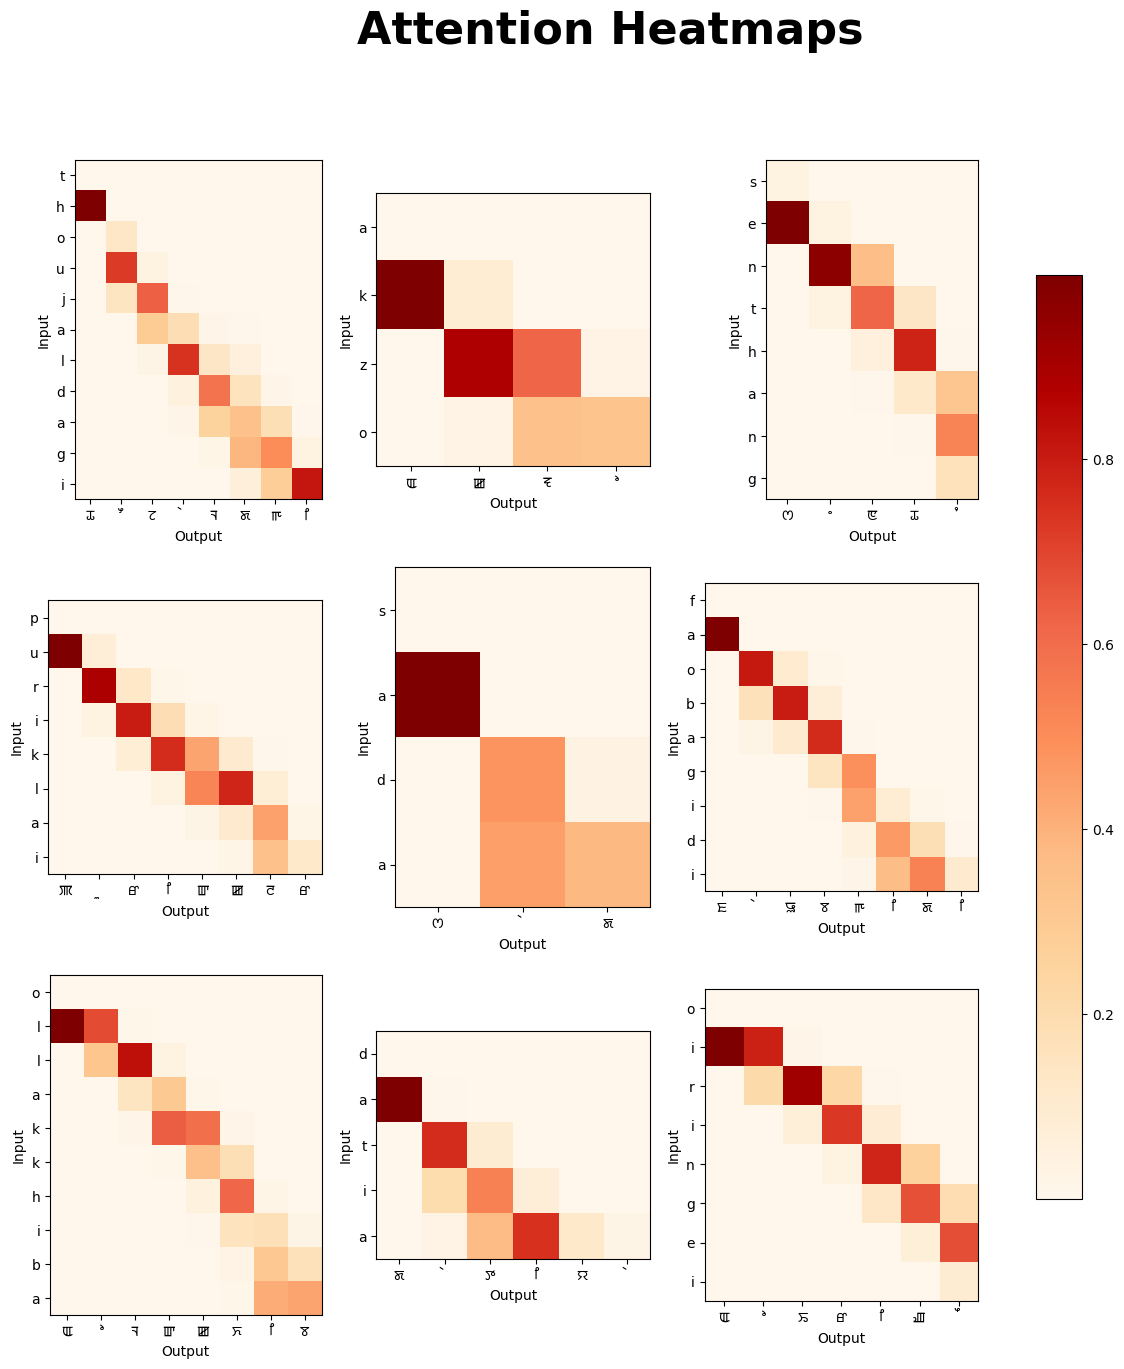

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cs20b001 (abdullah_010). Use `wandb login --relogin` to force relogin


In [94]:
random_pairs = random_pairs = random.sample(test_pairs, 9)
decoded_strs, decoder_attentions_list = [], []

for i in range(9):
    decoded_str, decoder_attentions = evaluateAttention(encoder, decoder, random_pairs[i][0])
    if decoded_str[-5:] == '<EOS>':
        decoded_str = decoded_str[:-5]
    decoded_strs.append(decoded_str)
    decoder_attentions_list.append(decoder_attentions[:len(decoded_str), :len(random_pairs[i][0])])

fig = plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Attention Heatmaps', fontsize=32, fontweight='bold')

for i in range(9):
    attention_vals = decoder_attentions_list[i].unsqueeze(0).cpu().numpy()[0].T
    im = axes[i // 3, i % 3].imshow(attention_vals, cmap='OrRd')
    axes[i // 3, i % 3].set_yticks(range(len(random_pairs[i][0])))
    axes[i // 3, i % 3].set_xticks(range(len(decoded_strs[i])))
    axes[i // 3, i % 3].set_yticklabels([char for char in random_pairs[i][0]])
    axes[i // 3, i % 3].set_xticklabels([char for char in decoded_strs[i]], fontproperties=mpl.font_manager.FontProperties(fname=fpath))
    axes[i // 3, i % 3].set_ylabel('Input')
    axes[i // 3, i % 3].set_xlabel('Output')
    

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

run = wandb.init(project='attention-heatmaps', reinit=True)
wandb.log({"Attention Heatmaps": [wandb.Image(fig)]})
run.finish()

In [1]:
def Q2():
    sweep(model_type='vanilla')

# Q2()

In [2]:
def Q4():
    best_config_vanilla = {'cell_type': 'lstm', 'dropout': 0.0, 'embedding_size': 256, 'epochs': 10, 'hidden_layer_size': 256, 'learning_rate': 0.0005, 'num_hidden_layers': 3, 'optimizer': 'Adam', 'beam_width': 1}

    encoder = EncoderRNN(input_lang.n_chars, best_config_vanilla['embedding_size'], best_config_vanilla['hidden_layer_size'], best_config_vanilla['num_hidden_layers'], dropout=best_config_vanilla['dropout'], cell_type=best_config_vanilla['cell_type']).to(device)
    decoder = DecoderRNN(best_config_vanilla['hidden_layer_size'], best_config_vanilla['embedding_size'], output_lang.n_chars, best_config_vanilla['num_hidden_layers'], dropout=best_config_vanilla['dropout'], cell_type=best_config_vanilla['cell_type']).to(device)
    optimizer = optim.SGD if best_config_vanilla['optimizer'] == 'SGD' else optim.Adam

    trainBatch(encoder, decoder, best_config_vanilla['epochs'], optimizer=optimizer, beam_width=best_config_vanilla['beam_width'], print_every=100, learning_rate=best_config_vanilla['learning_rate'])

    torch.save(encoder.state_dict(), 'vanilla_model/encoder.pt')
    torch.save(decoder.state_dict(), 'vanilla_model/decoder.pt')

    encoder.load_state_dict(torch.load('vanilla_model/encoder.pt'))
    decoder.load_state_dict(torch.load('vanilla_model/decoder.pt'))

    print(evalAccuracy(evaluateVanilla, encoder, decoder, test_pairs))
    evaluateRandomly(evaluateVanilla, encoder, decoder, type='test')

    prediction_pairs = []

    for pair in test_pairs:
        output_word = evaluateVanilla(encoder, decoder, pair[0])
        if output_word[-5:] == '<EOS>':
            output_word = output_word[:-5]
        prediction_pairs.append((pair[0], output_word))

    with open('predictions_vanilla/predictions.csv', 'w') as f:
        for pair in prediction_pairs:
            f.write(pair[0] + ',' + pair[1] + '\n')

# Q4()

In [3]:
def Q5():
    sweep(model_type='attention')

    best_config_attention = {'cell_type': 'gru', 'dropout': 0.2, 'embedding_size': 64, 'epochs': 10, 'hidden_layer_size': 128, 'learning_rate': 0.0005, 'num_hidden_layers': 1, 'optimizer': 'Adam', 'beam_width': 1}

    encoder = EncoderRNN(input_lang.n_chars, best_config_attention['embedding_size'], best_config_attention['hidden_layer_size'], best_config_attention['num_hidden_layers'], dropout=best_config_attention['dropout'], cell_type=best_config_attention['cell_type']).to(device)
    decoder = AttnDecoderRNN(best_config_attention['hidden_layer_size'], best_config_attention['embedding_size'], output_lang.n_chars, best_config_attention['num_hidden_layers'], dropout=best_config_attention['dropout'], cell_type=best_config_attention['cell_type']).to(device)
    optimizer = optim.SGD if best_config_attention['optimizer'] == 'SGD' else optim.Adam

    trainBatch(encoder, decoder, best_config_attention['epochs'], optimizer=optimizer, beam_width=best_config_attention['beam_width'], print_every=100, learning_rate=best_config_attention['learning_rate'])

    torch.save(encoder.state_dict(), 'attention_model/encoder.pt')
    torch.save(decoder.state_dict(), 'attention_model/decoder.pt')

    encoder.load_state_dict(torch.load('attention_model/encoder.pt'))
    decoder.load_state_dict(torch.load('attention_model/decoder.pt'))

    prediction_pairs = []

    for pair in test_pairs:
        output_word, _ = evaluateAttention(encoder, decoder, pair[0])
        if output_word[-5:] == '<EOS>':
            output_word = output_word[:-5]
        prediction_pairs.append((pair[0], output_word))

    with open('predictions_attention/predictions.csv', 'w') as f:
        for pair in prediction_pairs:
            f.write(pair[0] + ',' + pair[1] + '\n')

    print(evalAccuracy(evaluateAttention, encoder, decoder, test_pairs))

    random_pairs = random_pairs = random.sample(test_pairs, 9)
    decoded_strs, decoder_attentions_list = [], []

    for i in range(9):
        decoded_str, decoder_attentions = evaluateAttention(encoder, decoder, random_pairs[i][0])
        if decoded_str[-5:] == '<EOS>':
            decoded_str = decoded_str[:-5]
        decoded_strs.append(decoded_str)
        decoder_attentions_list.append(decoder_attentions[:len(decoded_str), :len(random_pairs[i][0])])

    fig = plt.figure(figsize=(15, 15))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    fig.suptitle('Attention Heatmaps', fontsize=32, fontweight='bold')

    for i in range(9):
        attention_vals = decoder_attentions_list[i].unsqueeze(0).cpu().numpy()[0].T
        im = axes[i // 3, i % 3].imshow(attention_vals, cmap='OrRd')
        axes[i // 3, i % 3].set_yticks(range(len(random_pairs[i][0])))
        axes[i // 3, i % 3].set_xticks(range(len(decoded_strs[i])))
        axes[i // 3, i % 3].set_yticklabels([char for char in random_pairs[i][0]])
        axes[i // 3, i % 3].set_xticklabels([char for char in decoded_strs[i]], fontproperties=mpl.font_manager.FontProperties(fname=fpath))
        axes[i // 3, i % 3].set_ylabel('Input')
        axes[i // 3, i % 3].set_xlabel('Output')
        

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
    plt.show()

    run = wandb.init(project='attention-heatmaps', reinit=True)
    wandb.log({"Attention Heatmaps": [wandb.Image(fig)]})
    run.finish()

# Q5()